In [754]:
import numpy as np
from scipy.special import gamma
from scipy.special import digamma, loggamma
from numpy.linalg import inv,det, slogdet
import pandas as pd
import scipy
import matplotlib.pyplot as plt
% matplotlib inline
import os

In [745]:

x1=pd.read_csv('./data_csv/X_set1.csv',header=None)
x2=pd.read_csv('./data_csv/X_set2.csv',header=None)
x3=pd.read_csv('./data_csv/X_set3.csv',header=None)
y1=pd.read_csv('./data_csv/y_set1.csv',header=None)
y2=pd.read_csv('./data_csv/y_set2.csv',header=None)
y3=pd.read_csv('./data_csv/y_set3.csv',header=None)
z1=pd.read_csv('./data_csv/z_set1.csv',header=None)
z2=pd.read_csv('./data_csv/z_set2.csv',header=None)
z3=pd.read_csv('./data_csv/z_set3.csv',header=None)

Define the Variation-model

In [763]:
class Gamma_Normal_VI():
    def __init__(self,x, y,a0=10**(-16),b0=10**(-16),e0=1,f0=1):
        self.x=x.squeeze()
        self.y=y.squeeze()  
        self.d=x.shape[1]
        self.n=x.shape[0]
        self.a0=a0
        self.b0=b0
        self.e0=e0
        self.f0=f0
        self.E_a=[a0/b0] *self.d
        self.E_lambda=e0/f0
        self.cov=inv( np.diag(self.E_a)+ self.E_lambda* x.T.dot(x) )
        self.u=self.cov.dot(x.T).dot(y).squeeze()*self.E_lambda
        self.q_a=np.repeat(self.a0,self.d)
        self.q_b=np.repeat(self.b0,self.d)
        self.q_e=e0
        self.q_f=f0
        self.object_values=[]

    def update_q_lambda(self):
        E_square_y_xw=np.sum( (self.y-self.x.dot(self.u))**2)+np.trace(self.x.dot(self.cov).dot(self.x.T))
        self.q_f=self.f0+E_square_y_xw/2
        self.q_e=self.e0+self.n/2
    
    def update_q_ai(self):
        E_square_w=self.u**2+np.diagonal(self.cov)
        self.q_b=np.repeat(self.b0,self.d)+0.5*E_square_w
        self.q_a=np.repeat(self.a0,self.d)+0.5


    def update_q_w(self):
        self.E_a=self.q_a/self.q_b
        self.E_lambda=self.q_e/self.q_f
        self.cov=inv( np.diag(self.E_a)+ self.E_lambda* self.x.T.dot(self.x) )     
        self.u=(self.cov.dot(self.x.T).dot(self.y)).squeeze()*self.E_lambda
        
    def object_function(self):
        

        Eln_plambda=(np.log(self.f0**self.e0/gamma(self.e0))
                    +(self.e0-1)*(digamma(self.q_e)-np.log(self.q_f))
                    -self.f0*self.q_e/self.q_f)
        Eln_pa=np.sum( np.log(self.b0**self.a0/gamma(self.a0))
                      +(self.a0-1)*(digamma(self.q_a)-np.log(self.q_b))
                      -self.b0*self.q_a/self.q_b)
        
        Eln_pw=(-0.5*self.d*np.log(2*np.pi)+
                0.5*np.sum( digamma(self.q_a)-np.log(self.q_b))-
                0.5*np.sum(self.E_a* (self.u**2+np.diagonal(self.cov)) )
                )
        
        Eln_py=(-0.5*self.n*np.log(2*np.pi)+
                0.5*self.n*( digamma(self.q_e)-np.log(self.q_f))-
                0.5*self.E_lambda*( np.sum( (self.y-self.x.dot(self.u))**2)
                                   + np.trace(self.x.dot(self.cov).dot(self.x.T)))
               )
        Eln_qlambda=( self.q_e*np.log(self.q_f)-loggamma(self.q_e)
                    +(self.q_e-1)*(digamma(self.q_e)-np.log(self.q_f))
                    -self.q_f*self.q_e/self.q_f
                    )
        Eln_qa=np.sum(np.log(self.q_b**self.q_a/gamma(self.q_a))
                     +(self.q_a-1)*(digamma(self.q_a)-np.log(self.q_b))
                     -self.q_b*self.q_a/self.q_b)
        Eln_qw=(-self.d/2*np.log(2*np.pi)-
                  0.5*slogdet(self.cov)[1]-
                  0.5*np.sum( inv(self.cov)*self.cov))
        L=Eln_plambda+Eln_pa+Eln_pw+Eln_py-Eln_qlambda-Eln_qa-Eln_qw
        self.object_values.append(L)
    
    def iterate(self, T=100):
        for t in range(T):
            self.update_q_lambda()
            self.update_q_ai()
            self.update_q_w()
            self.object_function()             

        

For data set one

/Users/hongbozhu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'object value')

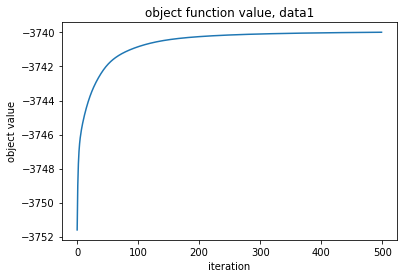

In [779]:
vi=Gamma_Normal_VI(x1,y1)
vi.iterate(T=500)
plt.plot(np.arange(len(vi.object_values)), vi.object_values)
plt.title('object function value, data1')
plt.xlabel('iteration')
plt.ylabel('object value')

Text(0.5,1,'1/E(a), data 1')

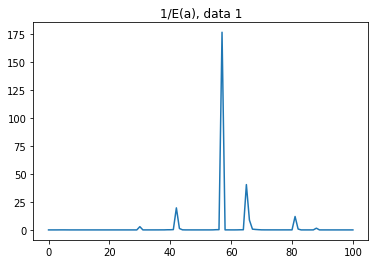

In [780]:
plt.plot(range(vi.d), 1/ vi.E_a )
plt.title('1/E(a), data 1')

In [782]:
print('data1, 1/e(lambda): ',1/ vi.E_lambda)

data1, 1/e(lambda):  1.0798136070941347


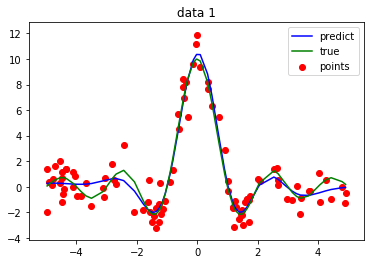

In [784]:
plt.plot(z1, x1.dot(vi.u.T), color='blue', label='predict' )
plt.scatter(z1,y1, color='red', label='points')
plt.plot(z1,10*np.sinc(z1),color='green',label='true')
plt.title('data 1')
plt.legend()

/Users/hongbozhu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'object value')

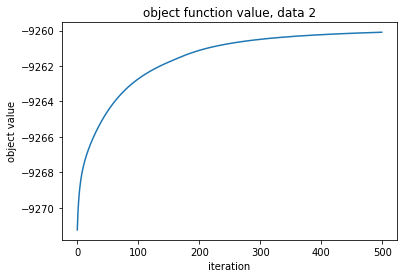

In [790]:
vi=Gamma_Normal_VI(x2,y2)
vi.iterate(T=500)
plt.plot(np.arange(len(vi.object_values)), vi.object_values)
plt.title('object function value, data 2')
plt.xlabel('iteration')
plt.ylabel('object value')

Text(0.5,1,'1/E(a), data 2')

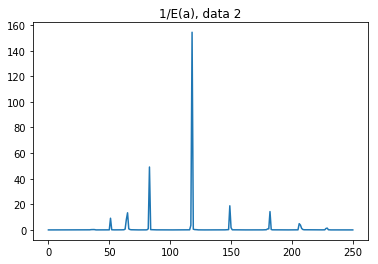

In [791]:
plt.plot(range(vi.d), 1/ vi.E_a )
plt.title('1/E(a), data 2')

In [793]:
print('data2, 1/e(lambda): ',1/ vi.E_lambda)

data2, 1/e(lambda):  0.8994494157119253


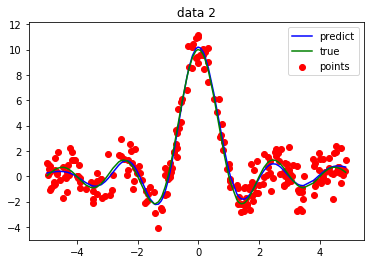

In [795]:
plt.plot(z2, x2.dot(vi.u.T), color='blue', label='predict' )
plt.scatter(z2,y2, color='red', label='points')
plt.plot(z2,10*np.sinc(z2),color='green',label='true')
plt.title('data 2')
plt.legend()

/Users/hongbozhu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'object value')

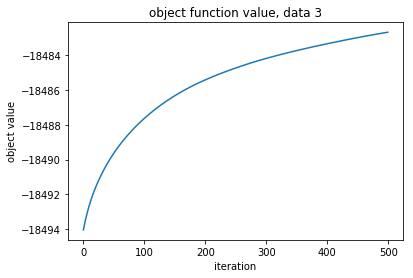

In [797]:
vi=Gamma_Normal_VI(x3,y3)
vi.iterate(T=500)
plt.plot(np.arange(len(vi.object_values)), vi.object_values)
plt.title('object function value, data 3')
plt.xlabel('iteration')
plt.ylabel('object value')

Text(0.5,1,'1/E(a), data 3')

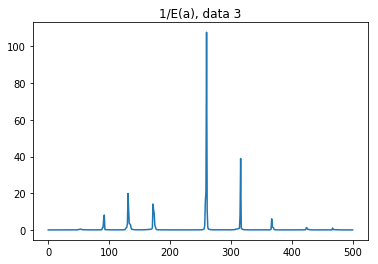

In [798]:
plt.plot(range(vi.d), 1/ vi.E_a )
plt.title('1/E(a), data 3')

In [799]:
print('data3, 1/e(lambda): ',1/ vi.E_lambda)

data3, 1/e(lambda):  0.9781004519762831


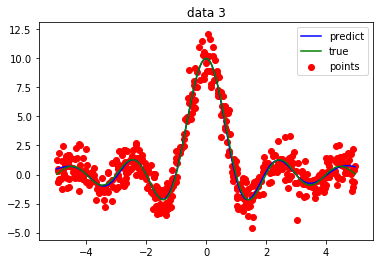

In [800]:
plt.plot(z3, x3.dot(vi.u.T), color='blue', label='predict' )
plt.scatter(z3,y3, color='red', label='points')
plt.plot(z3,10*np.sinc(z3),color='green',label='true')
plt.title('data 3')
plt.legend()